$ h_{out} = \frac{1}{2}$

# Convolucional Neuronal Network

In [30]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# 
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision import models
import matplotlib.pyplot as plt

## Upload database

In [31]:
data_path = '/home/juangomez/Desktop/ML/Cursos/Pepe Cantoral/datasets'
num_train = 50000
num_val = 5000
num_test = 5000
batch_size = 64


transform_cifar = T.Compose([
    T.ToTensor(),
    T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
])

# Training set
cifar10_train = datasets.CIFAR10(
    data_path,
    train=True,
    download=True,
    transform=transform_cifar)
train_loader = DataLoader(
    cifar10_train,
    batch_size=batch_size,
    sampler=sampler.SubsetRandomSampler(range(num_train)))

# Validation set
cifar10_val = datasets.CIFAR10(
    data_path,
    train= False,
    download=True,
    transform=transform_cifar)
val_loader = DataLoader(
    cifar10_val,
    batch_size=batch_size,
    sampler=sampler.SubsetRandomSampler(range(num_val)))

# Test set
cifar10_test = datasets.CIFAR10(
    data_path,
    train=False,
    download=True,
    transform= transform_cifar)
test_loader = DataLoader(
    cifar10_test,
    batch_size=batch_size,
    sampler=sampler.SubsetRandomSampler(range(num_test, num_test + num_val))
)


In [32]:
# this make a generator
data_iter = iter(train_loader)
# get the first batch
images, labels = next(data_iter)
print(images.shape)

torch.Size([64, 3, 32, 32])


# Choose Device

In [33]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cpu


## Show images

Show the image 0 of the batch 77. Class: 


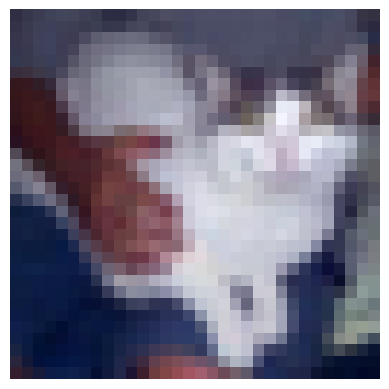

In [34]:
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

def plot_figure(image):
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

idx= np.random.randint(len(test_loader))
print(f'Show the image 0 of the batch {idx}. Class: ')
image = test_loader.dataset[idx][0]
image = (image- image.min())/(image.max()-image.min())
plot_figure(image)

# Accuracy


In [35]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model.to(device)
    with torch.no_grad():
        for xi, yi in loader:
            xi = xi.to(device)
            yi = yi.to(device)
            scores = model(xi)
            # Compute the max in each row for each image of the batch
            _, preds = scores.max(1)
            num_correct += (preds == yi).sum()
            num_total += len(yi)
        return float(num_correct) / num_total

# Training Loop

In [36]:
def train(model, optimizer, epochs=100):
    model = model.to(device = device)
    for epoch in range(epochs):
        model.train()
        for (xi, yi) in train_loader:
            xi = xi.to(device = device, dtype=torch.float32)
            yi = yi.to(device = device, dtype=torch.long)
            scores = model(xi)

            cost = F.cross_entropy(input=scores, target=yi.squeeze())

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()
        acc = accuracy(model, val_loader)
        if epoch%1 == 0:
            print(f'Epoch {epoch}, Cost: {cost.item()}, accuracy: {acc}')


# Secuential linear

In [37]:
hidden1 = 256
hidden2 = 256
lr = 1e-3
epochs = 10
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features = 3*32*32, out_features=hidden1), nn.ReLU(),
    nn.Linear(in_features = hidden1, out_features=hidden2), nn.ReLU(),
    nn.Linear(in_features = hidden2, out_features=10), nn.ReLU()
)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas= (0.9, 0.999))
train(model, optimizer, epochs=epochs)

Epoch 0, Cost: 1.3615127801895142, accuracy: 0.48
Epoch 1, Cost: 1.1977559328079224, accuracy: 0.499
Epoch 2, Cost: 1.0292707681655884, accuracy: 0.511
Epoch 3, Cost: 1.2579947710037231, accuracy: 0.4992
Epoch 4, Cost: 1.0519800186157227, accuracy: 0.5298
Epoch 5, Cost: 1.0020697116851807, accuracy: 0.5366
Epoch 6, Cost: 1.1797503232955933, accuracy: 0.5332
Epoch 7, Cost: 1.1155821084976196, accuracy: 0.5336
Epoch 8, Cost: 0.6970008611679077, accuracy: 0.53
Epoch 9, Cost: 1.7788828611373901, accuracy: 0.5368


# Sequetial CNN

In [38]:
channel1 = 16
channel2 = 32
epochs = 10
lr = 1e-3

modelCNN1 = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=channel1, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=channel1, out_channels=channel2, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(in_features=16*16*channel2, out_features=10)
)

optimizer = torch.optim.Adam(modelCNN1.parameters(), lr=lr, betas= (0.9, 0.999))
train(modelCNN1, optimizer, epochs=epochs)

Epoch 0, Cost: 1.0483596324920654, accuracy: 0.6396
Epoch 1, Cost: 1.3102608919143677, accuracy: 0.6716
Epoch 2, Cost: 1.081221342086792, accuracy: 0.6782
Epoch 3, Cost: 0.7491334080696106, accuracy: 0.683
Epoch 4, Cost: 0.9595288038253784, accuracy: 0.673
Epoch 5, Cost: 0.859831690788269, accuracy: 0.6792
Epoch 6, Cost: 0.984738290309906, accuracy: 0.669
Epoch 7, Cost: 0.4743129014968872, accuracy: 0.6606
Epoch 8, Cost: 0.6012346744537354, accuracy: 0.6562
Epoch 9, Cost: 0.2769041061401367, accuracy: 0.6574


In [39]:
acc = accuracy(modelCNN1, test_loader)
print(f'Accuracy test: {acc}')

Accuracy test: 0.6498
